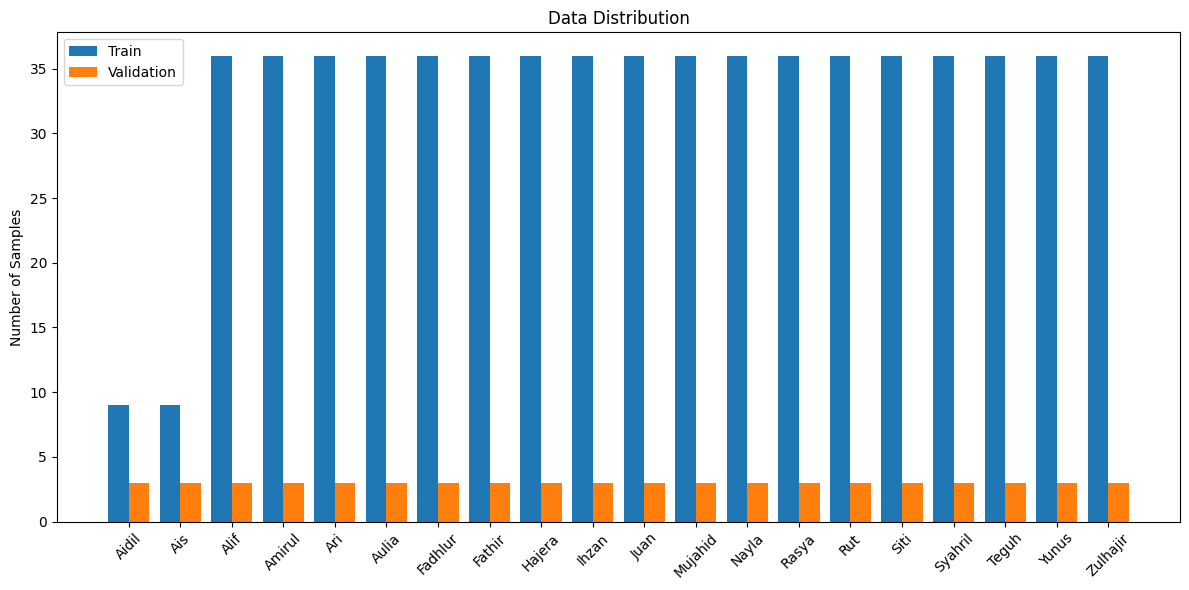

Random Forest Validation Accuracy: 0.95
Random Forest Classification Report:
              precision    recall  f1-score   support

       Aidil       1.00      1.00      1.00         3
         Ais       1.00      1.00      1.00         3
        Alif       1.00      0.67      0.80         3
      Amirul       0.75      1.00      0.86         3
         Ari       1.00      1.00      1.00         3
       Aulia       0.75      1.00      0.86         3
     Fadhlur       1.00      1.00      1.00         3
      Fathir       1.00      1.00      1.00         3
      Hajera       0.75      1.00      0.86         3
       Ihzan       1.00      1.00      1.00         3
        Juan       1.00      1.00      1.00         3
     Mujahid       1.00      1.00      1.00         3
       Nayla       1.00      1.00      1.00         3
       Rasya       1.00      1.00      1.00         3
         Rut       1.00      1.00      1.00         3
        Siti       1.00      1.00      1.00         3
    

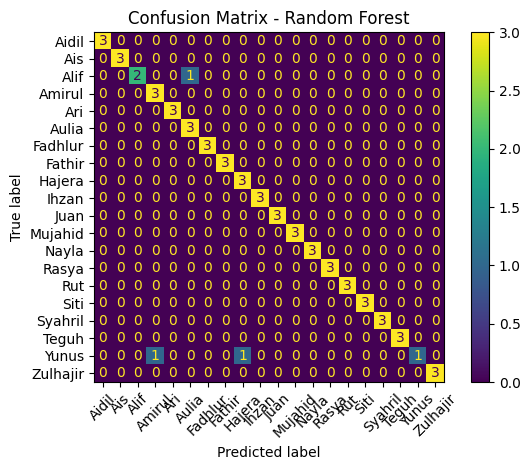

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def augment_image(image):
    """Performs data augmentation by applying random transformations."""
    rows, cols = image.shape

    # Apply random transformations
    M_rotate = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(-20, 20), 1)
    rotated = cv2.warpAffine(image, M_rotate, (cols, rows))

    flipped = cv2.flip(image, np.random.choice([-1, 0, 1]))  # Random flip
    return [image, rotated, flipped]

def augment_dataset(dataset_path):
    augmented_data = []
    augmented_labels = []
    class_names = os.listdir(dataset_path)
    class_names.sort()

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))

                augmented_images = augment_image(img)
                augmented_data.extend(augmented_images)
                augmented_labels.extend([label] * len(augmented_images))
    return np.array(augmented_data), np.array(augmented_labels), class_names

def load_dataset(dataset_path):
    data = []
    labels = []
    class_names = os.listdir(dataset_path)
    class_names.sort()

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels), class_names

def extract_hog_features(images):
    """Extracts HOG features from images."""
    hog = cv2.HOGDescriptor()
    features = [hog.compute(img).flatten() for img in images]
    return np.array(features)

def plot_data_distribution(y_train, y_val, class_names):
    train_counts = Counter(y_train)
    val_counts = Counter(y_val)

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(class_names)) - 0.2, train_counts.values(), width=0.4, label='Train')
    plt.bar(np.arange(len(class_names)) + 0.2, val_counts.values(), width=0.4, label='Validation')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.ylabel("Number of Samples")
    plt.title("Data Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_random_forest(X_train_hog_reduced, y_train, X_val_hog_reduced, y_val, class_names):
    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
    rf_model.fit(X_train_hog_reduced, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_val_hog_reduced)
    acc = accuracy_score(y_val, y_pred)
    print(f"Random Forest Validation Accuracy: {acc:.2f}")
    print(f"Random Forest Classification Report:\n{classification_report(y_val, y_pred, target_names=class_names, zero_division=0)}")
    
    # Plot confusion matrix
    print("Confusion Matrix for Random Forest:")
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=class_names, xticks_rotation=45)
    plt.title("Confusion Matrix - Random Forest")
    plt.tight_layout()
    plt.show()

    return rf_model

# Define dataset paths
train_path = "dataset_signature/train"
val_path = "dataset_signature/validation"

# Load and augment dataset
X_train, y_train, class_names = augment_dataset(train_path)
X_val, y_val, _ = load_dataset(val_path)

# Plot data distribution
plot_data_distribution(y_train, y_val, class_names)

# Feature extraction using HOG
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)

# Reduce dimensions with PCA
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_hog_reduced = pca.fit_transform(X_train_hog)
X_val_hog_reduced = pca.transform(X_val_hog)

# Train and evaluate Random Forest model
rf_model = evaluate_random_forest(X_train_hog_reduced, y_train, X_val_hog_reduced, y_val, class_names)